## Importing modules

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import nltk
from nltk.corpus import stopwords, cmudict
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import multiprocessing
import re

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings


## Loading Data

In [25]:
df = pd.read_csv('learning-agency-lab-automated-essay-scoring-2/train.csv')

In [26]:
df.head()

,essay_id,full_text,score
0,000d118,Many people have car where they live. The thin...,3
1,000fe60,I am a scientist at NASA that is discussing th...,3
2,001ab80,People always wish they had the same technolog...,4
3,001bdc0,"We all heard about Venus, the planet without a...",4
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3


## Preprocessing the dataset

In [27]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [28]:
def data_preprocessing(df):

    for index, row in df.iterrows():
        text_value = row['full_text']

            # lowercasing
        text_value = text_value.lower()

            # Remove URLs
        text_value = remove_urls(text_value)

            # Remove punctuation
        text_value = re.sub(r'[^\w\s]', '', text_value)

            # remove stopwords
        stop_words = set(stopwords.words('english'))
        text_value = ' '.join([word for word in text_value.split() if word not in stop_words])

            # lemmatization
        lemmatizer = WordNetLemmatizer()
        text_value = ' '.join([lemmatizer.lemmatize(word) for word in text_value.split()])
            
            # store the cleaned text
        df.at[index, 'text'] = text_value

    return df

In [29]:
data_preprocessing(df)

,essay_id,full_text,score,text
0,000d118,Many people have car where they live. The thin...,3,many people car live thing dont know use car a...
1,000fe60,I am a scientist at NASA that is discussing th...,3,scientist nasa discussing face mar explaining ...
2,001ab80,People always wish they had the same technolog...,4,people always wish technology seen movie best ...
3,001bdc0,"We all heard about Venus, the planet without a...",4,heard venus planet without almost oxygen earth...
4,002ba53,"Dear, State Senator\n\nThis is a letter to arg...",3,dear state senator letter argue favor keeping ...
...,...,...,...,...
17302,ffd378d,"the story "" The Challenge of Exploing Venus "" ...",2,story challenge exploing venus informative pie...
17303,ffddf1f,Technology has changed a lot of ways that we l...,4,technology changed lot way live today nowadays...
17304,fff016d,If you don't like sitting around all day than ...,2,dont like sitting around day great opportunity...
17305,fffb49b,"In ""The Challenge of Exporing Venus,"" the auth...",1,challenge exporing venus author suggests study...


## Data Visualisation

Check for missing values

In [30]:

missing = df.isnull().sum()
missing = missing[missing > 0]

if(missing.empty):
    print('No missing values')

else:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=missing.index, y=missing.values)
    plt.title('Missing values')
    plt.show()

No missing values


In [31]:
def count_unique_words(df):
    """
    Counts the number of unique words on the essays in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    num_unique_words (int): Number of unique words in the DataFrame.
    """

    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    unique_words = set(words)
    num_unique_words = len(unique_words)
    
    return num_unique_words


In [32]:
def get_average_essay_length(df):
    """
    Calculates the average length of essays in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_length (float): Average length of essays in terms of word count.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_words = len(words)
    num_essays = len(df)
    average_length = total_words / num_essays
    
    return average_length

In [33]:
def calculate_average_word_length(df):
    """
    Calculates the average length of words used in the essays.

    Parameters:
    df (DataFrame): DataFrame containing the essays.

    Returns:
    average_word_length (float): Average length of words in the essays.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    total_characters = sum(len(word) for word in words)
    total_words = len(words)
    average_word_length = total_characters / total_words
    
    return average_word_length

In [34]:
def get_most_common_words(df, stopwords_not_included=True, num_words=10):
    """
    Identifies the most common words used in the essays along with their counts.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    stopwords (bool): Whether to include stopwords or not. If true, stopwords will be removed.
    num_words (int): Number of most common words to return.

    Returns:
    common_words (list of tuples): List of tuples containing the most common words and their counts.
    """
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()

    if (stopwords_not_included == True):
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words]
    
    word_counts = Counter(words)
    common_words = word_counts.most_common(num_words)

    df_common_words = pd.DataFrame(common_words, columns=['Word', 'Count'])
    print(df_common_words)
    
    return common_words

In [35]:
def syllable_count_word(word):
    """
    Counts the number of syllables in a word using the CMU Pronouncing Dictionary.

    Parameters:
    word (str): The word for which syllable count needs to be calculated.

    Returns:
    syllable_count (int): The number of syllables in the word.
    """

    d = cmudict.dict()
    
    if word in d:
        syllable_count = max([len(list(y for y in x if y[-1].isdigit())) for x in d[word.lower()]])
    else:
        syllable_count = 1
    
    return syllable_count

def calculate_fkgl(text):
    """
    Calculates the Flesch-Kincaid Grade Level (FKGL) score for a given text.

    Parameters:
    text (str): The text for which FKGL score needs to be calculated.

    Returns:
    fkgl_score (float): The FKGL score of the text.
    """

    sentences = sent_tokenize(text)
    words = [word.lower() for sentence in sentences for word in word_tokenize(sentence)]
    
    syllable_count = 0
    for word in words:
        syllable_count += syllable_count_word(word)

    average_sentence_length = len(words) / len(sentences)
    average_syllables_per_word = syllable_count / len(words)

    fkgl_score = 0.39 * average_sentence_length + 11.8 * average_syllables_per_word - 15.59
    
    return fkgl_score


In [36]:
def plot_essay_length_distribution(df):
    """
    Plots a histogram showing the distribution of essay lengths in terms of word count.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    """
    
    all_essays = ' '.join(df['full_text'].tolist())
    words = all_essays.split()
    essay_lengths = [len(words) for words in df['full_text'].str.split()]
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(essay_lengths, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Essay Lengths')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [37]:
def plot_scores_frequency(df):
    """
    Plots a pie chart showing the distribution of scores in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the scores.
    """
    scores = df['score'].value_counts()
    plt.figure(figsize=(12, 6))
    plt.pie(scores.values, labels=scores.index, autopct='%1.1f%%')
    plt.title('Score distribution')
    plt.show()
    

In [38]:
def plot_essay_length_and_scores(df):
    """
    Plots a scatter plot showing the relationship between essay length and scores.

    Parameters:
    df (DataFrame): DataFrame containing the essays and scores.
    """
        
    essay_lengths = [len(words) for words in df['full_text'].str.split()]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(essay_lengths, df['score'], color='skyblue')
    plt.title('Essay Length vs. Score')
    plt.xlabel('Length of Essay (Word Count)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.show()

Number of unique words in the dataset: 129566
Average essay length in the dataset: 368.3482405962905
Average word length in the dataset: 4.557174326035612
FKGL Score of The Australian platypus is seemingly a hybrid of a mammal and reptilian creature is 11.264615384615386

Most common words in the dataset:
     Word  Count
0   would  43621
1  people  32374
2    cars  32012
3     car  30530
4   could  29338
5    like  22464
6   Venus  21637
7     get  17290
8    also  16948
9   think  15582


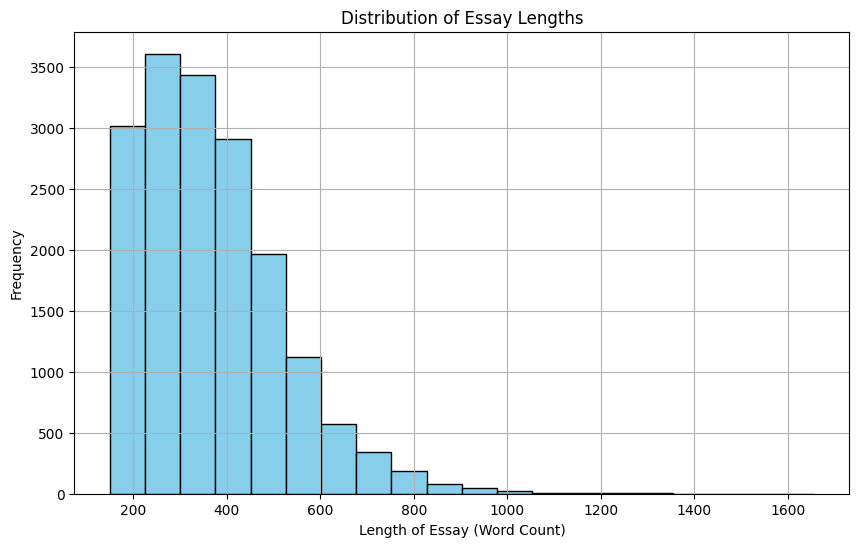

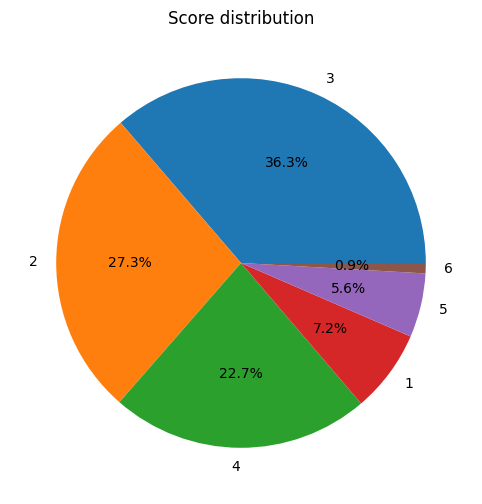

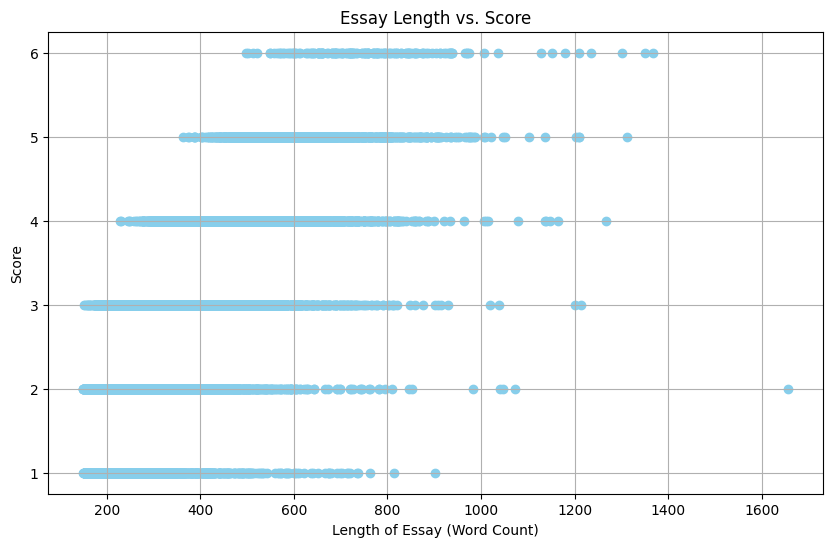

In [39]:
num_unique_words = count_unique_words(df)
average_essay_length = get_average_essay_length(df)
average_word_length = calculate_average_word_length(df)
print("Number of unique words in the dataset:", num_unique_words)
print("Average essay length in the dataset:", average_essay_length)
print("Average word length in the dataset:", average_word_length)
print("FKGL Score of The Australian platypus is seemingly a hybrid of a mammal and reptilian creature is" , calculate_fkgl("The Australian platypus is seemingly a hybrid of a mammal and reptilian creature"))
print("\nMost common words in the dataset:")
most_common_words = get_most_common_words(df)
plot_essay_length_distribution(df)
plot_scores_frequency(df)
plot_essay_length_and_scores(df)

## Model

In [40]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

def perform_tfidf(df, essay_col='full_text', max_features=1000, min_df=0.0, max_df=1.0, ngram_range=(1, 1), 
                  stop_words=None, tokenizer=None, use_idf=True, smooth_idf=True,
                  sublinear_tf=False, binary=False, norm='l2'):
    """
    Performs TF-IDF vectorization on the essays in the DataFrame.

    Parameters:
    df (DataFrame): DataFrame containing the essays.
    essay_col (str): Name of the column in the DataFrame that contains the essay texts.
    max_features (int or None): Maximum number of features (unique words) to consider.
    min_df (float or int): Minimum document frequency for words to be included.
    max_df (float or int): Maximum document frequency for words to be included.
    ngram_range (tuple): Range of n-grams to consider.
    stop_words (str, list, or None): Stop words to be ignored during tokenization.
    tokenizer (callable or None): Custom tokenizer function.
    use_idf (bool): Whether to use inverse document frequency (IDF) in TF-IDF calculation.
    smooth_idf (bool): Whether to add a constant term to the IDF calculation.
    sublinear_tf (bool): Whether to apply logarithmic scaling to term frequency (TF) values.
    binary (bool): Whether to use binary frequency counts instead of raw term frequencies.
    norm (str or None): Normalization method for the TF-IDF matrix.

    Returns:
    tfidf_matrix (array): TF-IDF matrix representing the essays.
    feature_names (list): List of feature names (words) corresponding to the columns of the TF-IDF matrix.
    """
    if essay_col not in df.columns:
        raise ValueError(f"The specified column '{essay_col}' does not exist in the DataFrame.")

    essays = df[essay_col].tolist()

    tfidf_vectorizer = TfidfVectorizer(max_features=max_features, min_df=min_df, max_df=max_df,
                                       ngram_range=ngram_range, stop_words=stop_words,
                                       tokenizer=tokenizer, use_idf=use_idf,
                                       smooth_idf=smooth_idf, sublinear_tf=sublinear_tf,
                                       binary=binary, norm=norm)
    
    tfidf_matrix = tfidf_vectorizer.fit_transform(essays)
    feature_names = tfidf_vectorizer.get_feature_names_out()

    return tfidf_matrix, feature_names


In [41]:
perform_tfidf(df)
tfidf_matrix, feature_names = perform_tfidf(df)


In [42]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    qwk = cohen_kappa_score(labels, predictions.clip(0, 5).round(0), weights='quadratic')
    results = {'qwk': qwk}
    return results

Classification Report:
              precision    recall  f1-score   support

           1       0.28      0.82      0.41       392
           2       0.39      0.52      0.44      1421
           3       0.61      0.08      0.13      1908
           4       0.38      0.42      0.40      1123
           5       0.26      0.52      0.35       296
           6       0.21      0.08      0.11        53

    accuracy                           0.35      5193
   macro avg       0.35      0.41      0.31      5193
weighted avg       0.45      0.35      0.31      5193

Accuracy: 0.35490082803774314
QWK Score: 0.5535641315219315
True Labels: [3 3 3 ... 4 5 4]
Predicted Labels: [4 4 2 ... 2 4 2]


c:\Users\manav\OneDrive\Desktop\NIT Surathkal\Semester 6\IT350\Summer\venv\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


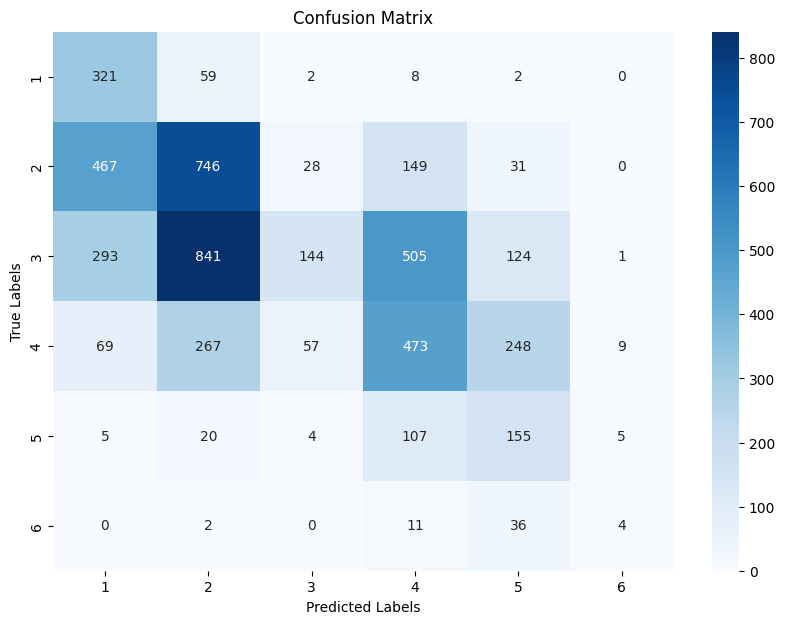

In [46]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, df['score'], test_size=0.3, random_state=42)

# model = LogisticRegression(max_iter=1000)
model = LogisticRegression(max_iter=1000, C=0.5, solver='saga', penalty='l1', class_weight='balanced', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model using classification metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))  
print("Accuracy:", accuracy_score(y_test, y_pred))

# Calculate and print the QWK Score
eval_pred = (y_pred, y_test)  # Define the tuple for predictions and actual labels
eval_results = compute_metrics(eval_pred)
print("QWK Score:", eval_results['qwk'])


# Print true and predicted labels
print("True Labels:", y_test.values)
print("Predicted Labels:", y_pred)

# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.unique(y_pred), yticklabels=np.unique(y_pred))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()